In [241]:
import pandas as pd
import numpy as np
import glob
from bs4 import BeautifulSoup
from pathlib import Path
pd.set_option('display.max_colwidth', 300)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from wordcloud import WordCloud
# import english stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vasyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Independent Natural Language Processing Project
Attached, you will find two text files: resume.txt and table_of_contents.txt. The first file contains a resume draft, and the second contains the truncated table of contents used to query for job listing results. Using these text files, we ask that you perform a few tasks and share your work with us. Our goal is to extract common data science skills from the downloaded job postings. Then you will compare these skills to our resume to determine which skills are missing.
#### Table of Contents
1.      Parse all text from the downloaded HTML files.  
2.      Explore the parsed output to learn how job skills are described in online postings. We’ll pay particular attention to whether certain HTML tags are more associated with skill descriptions.
3.      Attempt to filter any irrelevant job postings from the dataset.
4.      Cluster job skills based on text similarity.
5.      Visualize the clusters using word clouds.
6.      Adjust clustering parameters, if necessary, to improve the visualized output.
7.      Compare the clustered skills to our resume(*) to uncover missing skills.

Perform exploratory analysis on this dataset and produce a showcase/storyline of a few interesting patterns and your observations. You will walk us through your findings during our interview. You may use any tool you like, but a Jupyter notebook using Python is a common choice.  

1. Parse all text from the downloaded HTML files.

* Using the BeautifulSoup library, partsing files to do some exploration.
* After manual review of several files, I have noticed that for the majority of them the skills are in tag "li", which makes sense as it is a list of skills and usually formatted at that way.

In [242]:
path = r'job_postings'
files = glob.glob(path + r'/*.html')

* Let's see how many files have the skills in "li" tag.

In [243]:
has_list_tag = 0

for file in files:
    with open (file, 'r', encoding="utf8") as f:
        soup = BeautifulSoup(f, 'html.parser')
        if 'li' in set([str(tag.name) for tag in soup.find_all()]):
            has_list_tag += 1

print('Total Files with <li> tag: ', has_list_tag)
print('Total files count: ', len(files))
print('Total files with list tag %: ', round(has_list_tag/len(files) * 100))

Total Files with <li> tag:  1320
Total files count:  1458
Total files with list tag %:  91


* I think 91% - 1320 out of 1450 files is a good number to proceed with.
* we will also create new text files for easier access later on. Files with only skills in "li" tag will be saved in "job_postings_text_li_tags" folder. First sentence of the file will be the title of the file.

In [245]:
titles = []
skills = []

for file in files:
    with open (file, 'r', encoding="utf8") as f:
        soup = BeautifulSoup(f, 'html.parser')
        if 'li' in set([str(tag.name) for tag in soup.find_all()]):
            # get text only from <li> tags, separate by dot
            text = '. '.join([tag.text for tag in soup.find_all('li')])
            skills.append(text)
            # get text from <title> tag and append to titles list
            title = soup.title.text
            titles.append(title)
            # save new file text into directory job_postings_text_li_tags just in case
            if Path('job_postings_text_li_tags/' + Path(file).name[:-5] + '.csv').is_file():
                continue
            else:
                with open('job_postings_text_li_tags/' + Path(file).name[:-5] + '.csv', 'x', encoding="utf8") as f:
                    full_text = title + '|' + text
                    f.write(full_text)

3. Attempt to filter any irrelevant job postings from the dataset.

In [246]:
df = pd.DataFrame({'title': titles, 'skills': skills})
df.head()

,title,skills
0,"Data Scientist - Beavercreek, OH",Use statistical research methods to analyze datasets produced through multiple sources of intelligence production. Mine and analyze data from databases to answer key intelligence questions. Assess the effectiveness and accuracy of new data sources and data gathering techniques. Develop custom da...
1,"Data Scientist - Seattle, WA 98101","Interface with our internal engagement teams and clients to understand business questions, and perform analytical ""deep dives"" to develop relevant and interpretive insights in support of our client engagements. Smartly leverage appropriate technologies to answer tough questions or understand roo..."
2,"Data Scientist - Newark, CA","Design, develop, document and maintain machine learning tools (e.g. models) to extract hidden insights in the vast amount of data that Credit, Marketing and/or Operations can use to make their respective strategies and processes more efficient and effective. Be the subject matter expert in mac..."
3,"Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL","Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse. Accurately documents care provided. Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of ..."
4,"Data Manager / Analyst - Oakland, CA","You possess excellent communication and relationship-building skills with colleagues, partners and clients with utmost integrity, courtesy and diplomacy. You are capable of embracing the ideas of others and seek to understand others’ points of view in order to further our shared mission and visi..."


* let's see how many documents does not have "data" or "machine learning" in them.

In [247]:
df2 = df[ (~df['skills'].str.lower().str.contains('data') & ~df['title'].str.lower().str.contains('data'))
          & 
          (~df['skills'].str.lower().str.contains('machine learning') & ~df['title'].str.lower().str.contains('machine learning'))]
df2.shape

(88, 2)

* We can drop 88 documents that do not have "data" or "machine learning" in them. to filter out irrelevant job postings at least somewhat.

In [248]:
df = df.drop(df2.index)
df2.head(7)

,title,skills
3,"Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL","Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse. Accurately documents care provided. Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of ..."
50,Engineer I ( Electrical Engineer) - United States,Bachelor’s degree or higher in Electrical Engineering or Electrical Engineering Technology. EIT certification or on EIT certification track preferred. 2 years of internship or co-op type experience in an electrical engineering related role or equivalent within a paper producing facility preferre...
54,"Admissions Associate PT - Baldwin Park, CA","Communicate clearly and concisely within the department and with other hospital departments. Process patient's hospital admission documents, insurance information (including coverage verifications) and admission consents; provide information on admission policies/procedures to patients, family m..."
64,"System Validation Engineering Intern - Roseville, CA",Participates in implementation and validation of network solutions which integrate multiple Aruba Networking product lines as well as 3rd party products and applications. Develop automated apps and scripts for setup and validation of solutions and integration activities based on specific validat...
70,"Sales Development Intern - San Francisco, CA 94107","Develop a strong understanding of Unity Monetization products. Assist with preparation of media plans and proposals. Brainstorm creative executions that meet RFP goals, and align with Unity product offerings. Build app lists and targeting recommendations using a combination of internal and exter..."
80,"Environmental, Health and Safety Specialist III - Sacramento, CA 95817","Oversees and participates in the analysis of SMUD work environments and the design of programs to control, eliminate and prevent disease or injury caused by chemical, physical, and biological agents or ergonomic factors. Identifies potential health and safety hazards in existing or future system..."
102,"HR/Controller Dual - Lompoc, CA 93436","Recruits and screens applicants. Maintains employee files. Conducts employee orientation. Monitors employee training and development programs. Monitors performance review program for all employees at hotel. Complies with all company policies and procedures, local, state and federal laws and regu..."


In [249]:
df.shape

(1232, 2)

4. Cluster job skills based on text similarity.
  
I will be using k-means clustering algorithm to cluster the skills. I will be using the following steps to cluster the skills:
* Tokenize,Vectorize,Remove stop words from skills   
* Cluster the words using k-means clustering algorithm
* Visualize the clusters using word clouds
* Try adding:  * Lemmatize the words



In [251]:
stops = (stopwords.words('english'))
stops.extend(['experience','position','ability'])

vectorizer = TfidfVectorizer(stop_words=stops)
X = vectorizer.fit_transform(df['skills'])

In [252]:
print(vectorizer.get_feature_names_out())
print(X.shape)

['00' '000' '00am' ... 'ﬁeld' 'ﬁndings' 'ﬁtness']
(1232, 11873)


* Let's see how many clusters we will get. I will be using the elbow method to find the optimal number of clusters.

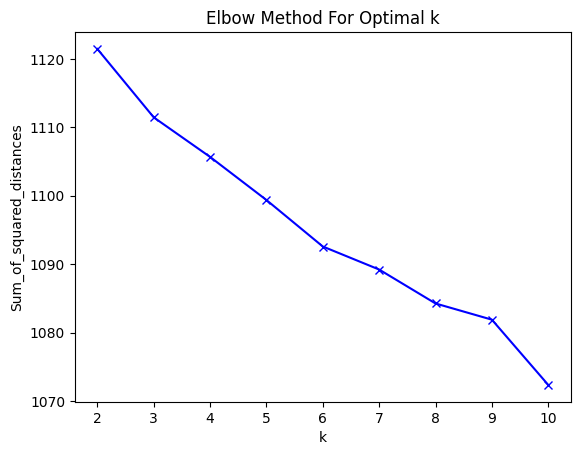

In [283]:
Sum_of_squared_distances = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=1)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

* It seems like hard to see, but 6 should be sufficient for our purposes. And with larges number it will be hard to make sence of the clusters.

In [280]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=77)
model.fit(X)
labels=model.labels_
df['cluster'] = labels

5. Visualize the clusters using word clouds. 
6. Adjust clustering parameters, if necessary, to improve the visualized output.
* After playing with different number of clusters I have decided to stop on 6.

Cluster: 0
Number of job postings: 376 - 30.52%


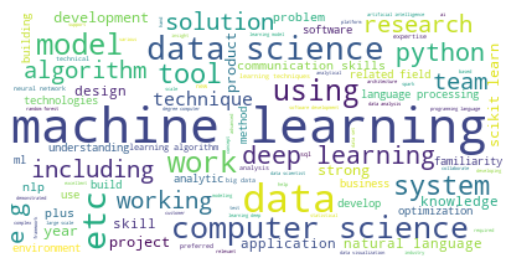

Cluster: 1
Number of job postings: 62 - 5.03%


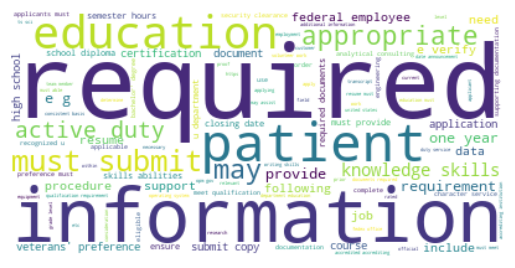

Cluster: 2
Number of job postings: 154 - 12.5%


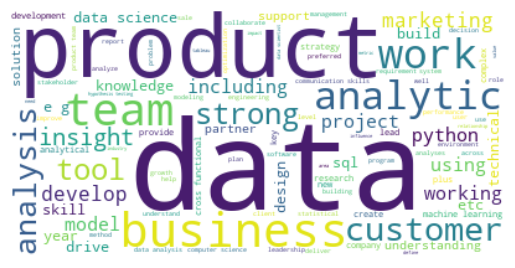

Cluster: 3
Number of job postings: 379 - 30.76%


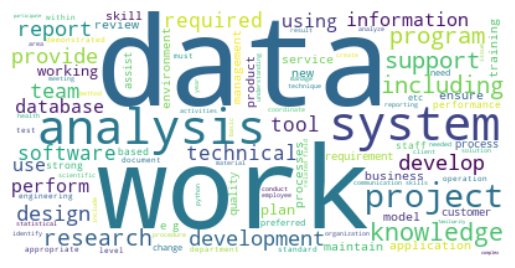

Cluster: 4
Number of job postings: 21 - 1.7%


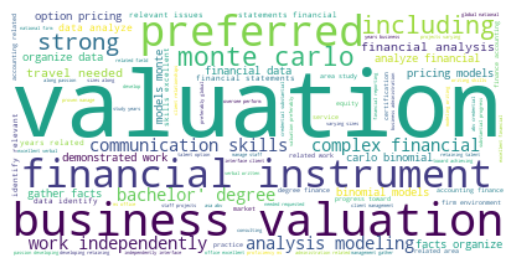

Cluster: 5
Number of job postings: 240 - 19.48%


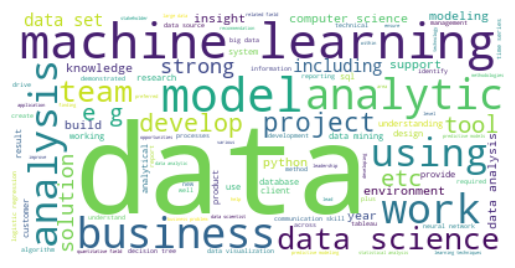

In [281]:
# remove stops from df['skills']
df['skills'] = df['skills'].str.lower()
df['skills'] = df['skills'].str.replace(r'\b(' + r'|'.join(stops) + r')\b', '', regex=True)


result={'cluster':df['cluster'],'skills':df['skills']}
result=pd.DataFrame(result)

for k in range(0,true_k):
    s = result[result.cluster == k]
    text = s['skills'].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
    print(f'Cluster: {k}')
    print(f'Number of job postings: {len(s)} - {round(len(s)/len(df)*100,2)}%')

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

* Looking at the clusters, I think we can make some sense of them.   
I will be leaving only claster 0, 2, 5 as those resemble out Data Science class the most.  
Cluster 1 - seems like health care / government jobs.  
Cluster 3 - seems like more of a general IT jobs.  
Cluster 4 - seems like Financial jobs.


In [284]:
df_filtered_jobs = df[df['cluster'].isin([0,2,5])]
df_filtered_jobs.reset_index(drop=True, inplace=True)
df_filtered_jobs.shape

(770, 3)

7. Compare the clustered skills to our resume(*) to uncover missing skills.